In [1]:
# Tools for monitoring audio and maybe recording too
%matplotlib inline

import pyaudio
import wave
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter
import sys
import time
import os


def make_folder(bird, sess, path_type, exp_folder = '/Volumes/gentner/earneodo/bci_zf/'):
    assert(os.path.isdir(os.path.abspath(exp_folder)))
    bird_folder = os.path.join(os.path.abspath(exp_folder), path_type, bird)
    sess_folder = os.path.join(bird_folder, str(sess).zfill(3))
    if not os.path.isdir(sess_folder):
        os.makedirs(sess_folder)
    return sess_folder

def dated_file_path(path_pars = None):
    if path_pars == None:
        sess_path = os.getcwd()
    else:
        try:
            sess_path = path_pars['sess_path']
        except:
            print 'Wrong path_parameters (sess_path key missing)'
    
    st = time.strptime(time.ctime())
    file_name = "{:04d}{:02d}{:02d}t{:02d}{:02d}{:02d}_sound.wav".format(st.tm_year, st.tm_mon, st.tm_mday, 
                                                                 st.tm_hour, st.tm_min, st.tm_sec)
    return os.path.join(sess_path, file_name)

def unpack_bits(stream, dtype='<h', n_chans=1):
    formatted = np.fromstring(stream, dtype=np.dtype(dtype))
    return formatted

def rms(x):
    return np.linalg.norm(np.array(x, dtype=np.int64))/np.sqrt(x.size)


def mad(x):
    med = np.median(x)
    dev = np.abs(x - np.median(x))
    return np.median(dev)

def msg(string):
    if not 'Armed' in string:
        print(string)
        sys.stdout.flush()
                
        
class audioBuffer:
    
    def __init__(self, dtype='<h', n_chans=1):
        self._stream = ''
        self.dtype = '<h'
        self.n_chans = n_chans

    def append(self, new_stream):
        self._stream = self._stream + new_stream
    
    def write(self, new_stream):
        self._stream = new_stream
        
    def read_binary(self):
        return self._stream
    
    # size in bytes
    def get_size(self):
        return len(self._stream)
    
    def get_n_formatted(self):
        return len(self._stream) / np.zeros(1, dtype=np.dtype(self.dtype)).nbytes
    
    def clear_data(self):
        self._stream = ''
    
    def read_formatted(self):
        return unpack_bits(self._stream, self.dtype, self.n_chans)


class Recorder:
    
    
    def __init__(self, channels=1, rate=44100, frames_per_buffer=4096, monitor_pars=None, path_pars=None):
        self.channels = channels
        self.rate = rate
        self.sampling_step_ms = 1000./rate
        self.frames_per_buffer = frames_per_buffer
        self._pa = pyaudio.PyAudio()
        self._stream = None
        self._filter = None
        self.stream_buffer = audioBuffer(dtype='<h', n_chans = channels)
        self.wavefile = None
        self.device = 0
    
        self._is_recording = False
        self.rms_thresh = 1500.
        self.rms_stop_thresh = 1000.
        self.monitor_channel = 0
        self.monitor_buffer_size_ms = 2000
        self.monitor_buffer_max_elem = self.monitor_buffer_size_ms/self.sampling_step_ms * channels
        self.monitor_status = 'off'
        self.recorded_samples = 0
        self.record_epoch_ms = 120000 #records maximum 120 sec epochs
        self.record_epoch_max_elem = self.record_epoch_ms/self.sampling_step_ms * channels
        self.ms_in_buf = 0
        self.callback_count = 0
        
        self.path_pars = path_pars
        self.monitor_pars = monitor_pars #TODO: for entering and updating monitor parameters (thresholds, channel, etc)
        
    def msec_to_frames(self, n_msec):
        return np.int(np.ceil(self.rate/(1000.*self.frames_per_buffer)*n_msec))
    
    
    def read_frames(self, n, msec=True):
        self._stream = self._pa.open(format=pyaudio.paInt16,
                                    channels=self.channels,
                                    rate=self.rate,
                                    input=True,
                                     input_device_index=self.device,
                                    frames_per_buffer=self.frames_per_buffer)
        self._is_recording = True
        n_frames = self.msec_to_frames(n) if msec else n_frames
        self.stream_buffer.clear_data()
        for frame in range(n_frames):
            self.stream_buffer.append(self._stream.read(self.frames_per_buffer))
        self._is_recording = False
        return self.stream_buffer
    
    def get_avg_rms(self, window_len = 3000):
        rms_buffer_formatted = self.read_frames(3000).read_formatted()
        
        return rms(rms_buffer_formatted), np.median(rms_buffer_formatted), mad(rms_buffer_formatted)
    
    
    def start_triggered_mode(self):
        msg("starting monitoring")
        self._stream = self._pa.open(format=pyaudio.paInt16,
                            channels=self.channels,
                            rate=self.rate,
                            input=True,
                            input_device_index=self.device,
                            frames_per_buffer=self.frames_per_buffer,
                            stream_callback=self.get_callback())
        
        self.stream_buffer.clear_data()
        self.monitor_status = 'armed'
        self._stream.start_stream()
        return self
    
    def stop_triggered_mode(self):
        msg('Stopping monitor: ' + self.monitor_status)
        if self.monitor_status == 'triggered':
            self.stop_triggered_recording()
            
        self._stream.stop_stream()
        self.monitor_status = 'off'
        
        
    def get_callback(self):
        def callback(in_data, frame_count, time_info, status):
            
            self.callback_count = self.callback_count + 1
            self.stream_buffer.append(in_data)            
            elem_in_buf = self.stream_buffer.get_n_formatted()
            

                #msg('rms is {}'.format(frames_rms))
            # Decide whether to analyze state of the machine
            if elem_in_buf > self.monitor_buffer_max_elem:
                if self._filter is None:
                    #msg('wont filter')
                    frames_rms = rms(self.stream_buffer.read_formatted())
                else:
                    #msg('Will filter')
                    frames_rms = rms(self._filter.do_filter(self.stream_buffer.read_formatted()))
                #print "full buffer"
                #plt.plot(self.stream_buffer.read_formatted())
                #msg(str(rms(self.stream_buffer.read_formatted())))
                
                if self.monitor_status == 'armed':
                    msg('Armed with rms ' + str(frames_rms))
                    
                    if frames_rms > self.rms_thresh:
                        msg('Should start recording')
                        self.start_triggered_recording()
                        self.recorded_samples = elem_in_buf

                
                elif self.monitor_status == 'triggered':
                    msg('Triggered with rms ' + str(frames_rms))
                    if frames_rms >= self.rms_stop_thresh:
                        self.continue_triggered_recording()
                        self.recorded_samples = self.recorded_samples + elem_in_buf
                        if self.recorded_samples > self.record_epoch_max_elem:
                            msg('Recording went too long, stopping it')
                            self.stop_triggered_recording()
                    else:
                        self.stop_triggered_recording()
                
                self.stream_buffer.clear_data()
            return in_data, pyaudio.paContinue
        return callback
    
    def start_triggered_recording(self):
        msg("Starting to record")
        file_name = self.make_file_path()
        self._prep_file(file_name)
        self._buffer_to_file()
        self.monitor_status = 'triggered'
        
    def continue_triggered_recording(self):
        msg("continuing recording")
        self._buffer_to_file()
    
    def stop_triggered_recording(self):
        msg("Recording Stopped")
        self._buffer_to_file()
        self._close_file()
        self.monitor_status = 'armed'
        return self
        
    def make_file_path(self):
        return dated_file_path(self.path_pars)
    
    def set_filter(self, filter_obj):
        self._filter = filter_obj
    
    def _prep_file(self, file_name, mode='wb'):
        msg("preparing file " + file_name)
        self.wavefile = wave.open(file_name, mode)
        self.wavefile.setnchannels(self.channels)
        self.wavefile.setsampwidth(self._pa.get_sample_size(pyaudio.paInt16))
        self.wavefile.setframerate(self.rate)
        msg('file open')
    
    def _close_file(self):
        self.wavefile.close()
        
    def _buffer_to_file(self):
        # send the data to file
        msg("storing data")
        self.wavefile.writeframes(self.stream_buffer.read_binary())
        #plt.plot(self.stream_buffer.read_formatted())
        self.stream_buffer.clear_data()


## Now do something with all this
exp_folder = '/home/earneodo/Data/'
bird = 'b1114'
sess = 7

sess_path = make_folder(bird, sess, 'raw_data', exp_folder=exp_folder)
moni = Recorder(path_pars={'sess_path': sess_path})
#moni.start_triggered_mode()
#bufread = moni.read_frames(1000)

In [2]:
class Filter:
    def __init__(self, filter_fun, *filter_args, **filter_kwargs):
        self.filter = filter_fun
        self.args = filter_args
        self.kwargs = filter_kwargs
        
    def do_filter(self, data):
        return self.filter(data, *self.args, **self.kwargs)        

def apply_filter(data, filter_b, filter_a):
    y = lfilter(filter_b, filter_a, data)
    return y

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

band_pass_filter = Filter(apply_filter, *butter_bandpass(500, 10000, moni.rate))
moni.set_filter(band_pass_filter)
moni.rms_thresh = 30.
moni.rms_stop_thresh = 20.

In [3]:
moni.start_triggered_mode()

starting monitoring


<__main__.Recorder instance at 0x7f61453743f8>

Should start recording
Starting to record
preparing file /home/earneodo/Data/raw_data/b1114/007/20170216t094322_sound.wav
file open
storing data
Triggered with rms 43.0622952551
continuing recording
storing data
Triggered with rms 37.9504361872
continuing recording
storing data
Triggered with rms 23.452647094
continuing recording
storing data
Triggered with rms 4.3384635097
Recording Stopped
storing data
Should start recording
Starting to record
preparing file /home/earneodo/Data/raw_data/b1114/007/20170216t094332_sound.wav
file open
storing data
Triggered with rms 5.26429921602
Recording Stopped
storing data
Should start recording
Starting to record
preparing file /home/earneodo/Data/raw_data/b1114/007/20170216t094346_sound.wav
file open
storing data
Triggered with rms 16.215562559
Recording Stopped
storing data
Should start recording
Starting to record
preparing file /home/earneodo/Data/raw_data/b1114/007/20170216t094352_sound.wav
file open
storing data
Triggered with rms 52.42004626

In [9]:
moni.stop_triggered_mode()

Stopping monitor: armed


In [8]:
moni.rms_thresh = 20.
moni.rms_stop_thresh = 15.

Triggered with rms 19.4788775096
continuing recording
storing data
Triggered with rms 22.4600724883
continuing recording
storing data
Triggered with rms 19.2264653882
continuing recording
storing data
Triggered with rms 19.4173228411
continuing recording
storing data
Triggered with rms 34.6140278783
continuing recording
storing data
Triggered with rms 26.2588714801
continuing recording
storing data
Triggered with rms 36.0492021737
continuing recording
storing data
Triggered with rms 27.246814583
continuing recording
storing data
Triggered with rms 11.1221337839
Recording Stopped
storing data
Should start recording
Starting to record
preparing file /home/earneodo/Data/raw_data/b1114/007/20170216t093428_sound.wav
file open
storing data
Triggered with rms 17.9975390052
continuing recording
storing data
Triggered with rms 34.5213454083
continuing recording
storing data
Triggered with rms 9.69298266316
Recording Stopped
storing data
Should start recording
Starting to record
preparing file /

In [5]:
moni.get_avg_rms()

Armed with rms 238.824464734


KeyboardInterrupt: 

254.698093705
254.247013576
171.0


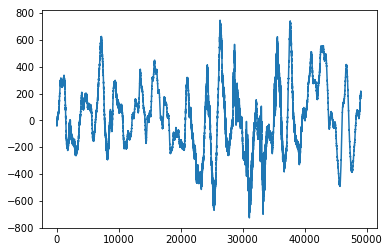

In [12]:
bufread = moni.read_frames(1024)
chunk = bufread.read_formatted()
plt.plot(chunk)
print rms(chunk)
print np.std(chunk)
print mad(chunk)

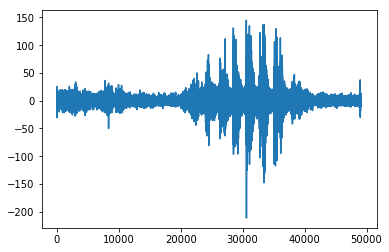

In [15]:
plt.plot(band_pass_filter.do_filter(chunk))

In [17]:
moni._pa.get_default_input_device_info()

{'defaultHighInputLatency': 0.034829931972789115,
 'defaultHighOutputLatency': 0.034829931972789115,
 'defaultLowInputLatency': 0.008707482993197279,
 'defaultLowOutputLatency': 0.008707482993197279,
 'defaultSampleRate': 44100.0,
 'hostApi': 0L,
 'index': 2L,
 'maxInputChannels': 32L,
 'maxOutputChannels': 32L,
 'name': u'default',
 'structVersion': 2L}

In [9]:
moni._pa.get_device_info_by_index(0)

{'defaultHighInputLatency': 0.034829931972789115,
 'defaultHighOutputLatency': 0.034829931972789115,
 'defaultLowInputLatency': 0.008707482993197279,
 'defaultLowOutputLatency': 0.008707482993197279,
 'defaultSampleRate': 44100.0,
 'hostApi': 0L,
 'index': 0,
 'maxInputChannels': 2L,
 'maxOutputChannels': 2L,
 'name': u'UA-22: USB Audio (hw:1,0)',
 'structVersion': 2L}

Should start recording
Starting to record
preparing file /home/earneodo/Data/raw_data/b1114/005/20170215t114809_sound.wav
file open
storing data
Triggered with rms 5.53776560741
continuing recording
storing data
Triggered with rms 2.4991919859
Recording Stopped
storing data
Should start recording
Starting to record
preparing file /home/earneodo/Data/raw_data/b1114/005/20170215t114831_sound.wav
file open
storing data
Triggered with rms 3.67745586522
continuing recording
storing data
Triggered with rms 2.08003319347
Recording Stopped
storing data


In [20]:
moni.stop_triggered_mode(1)

TypeError: stop_triggered_mode() takes exactly 1 argument (2 given)